In [1]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
tf.random.set_seed(7)
import kerastuner as kt
import xgboost as xgb
import time

#data split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew

#feature selection
from sklearn.feature_selection import RFECV

#models
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

#metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

#hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import Hyperband, BayesianOptimization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from kerastuner import HyperModel


#plots
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(r'C:\Users\Dondo\Desktop\NYC.csv', index_col=0)


#Normalize labels
labelEncoder = sklearn.preprocessing.LabelEncoder()
pd.options.mode.chained_assignment = None

# Data Exploration

In [2]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84548 entries, 4 to 8413
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING CLASS AT PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT NUMBER                84548 non-null  object
 10  ZIP CODE                        84548 non-null  int64 
 11  RESIDENTIAL UNITS               84548 non-null  int64 
 12  COMMERCIAL UNITS                84548 non-null 

In [4]:
#Sum of duplicates across the dataframe
sum(df.duplicated(df.columns))

765

In [5]:
#Drop duplicates
df = df.drop_duplicates(df.columns,keep = 'last')
sum(df.duplicated(df.columns))

0

<AxesSubplot:>

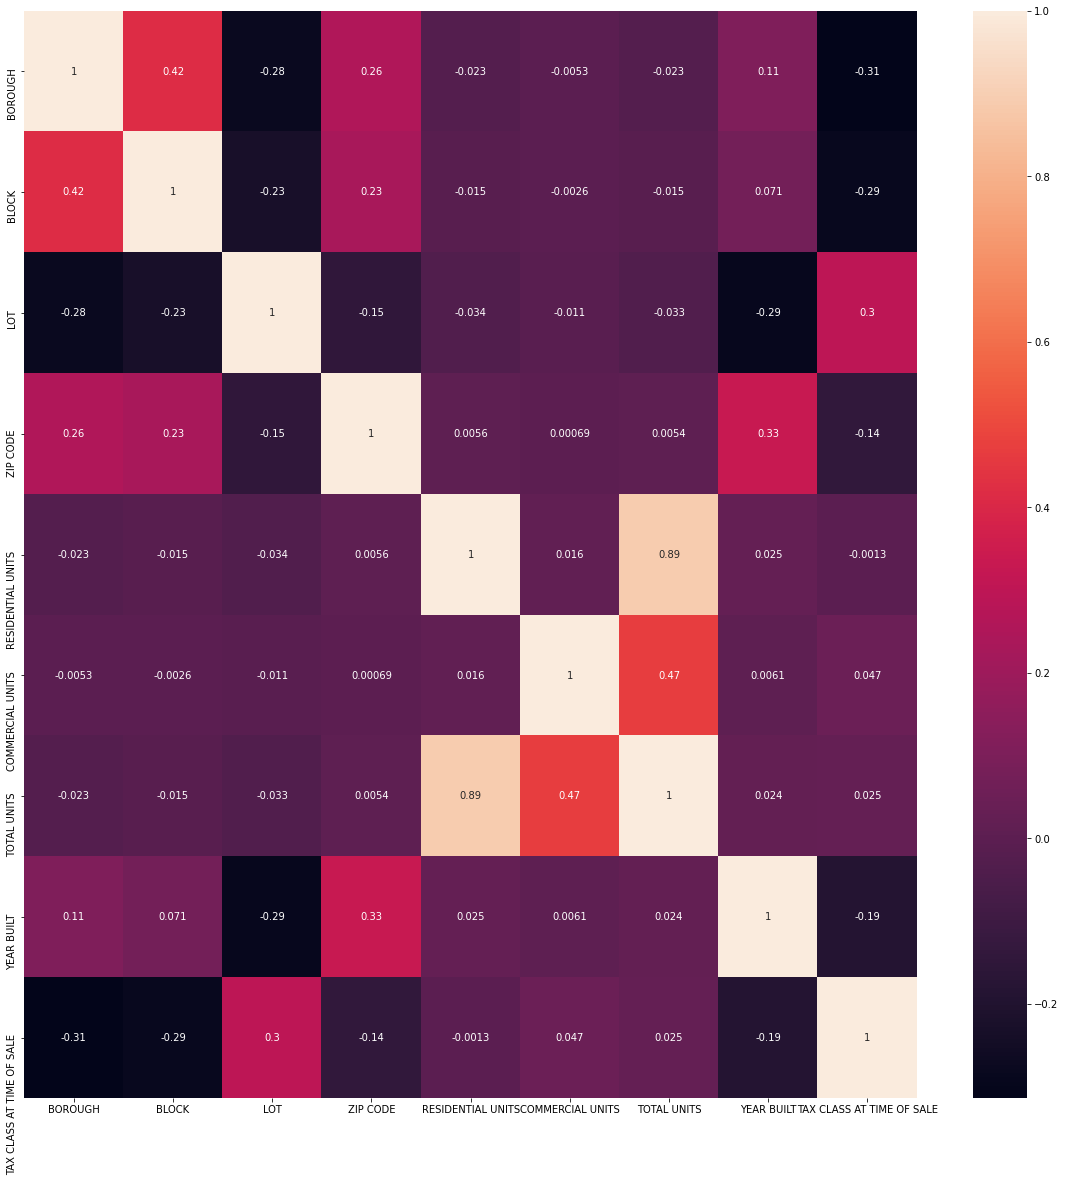

In [6]:
#Correlation Matrix 
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)

## Numeric Values

In [7]:
df.select_dtypes(include=[np.number]).describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE
count,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000,83783.000000
mean,2.999308,4242.903155,376.137415,10733.236575,1.999976,0.183677,2.213504,1789.814318,1.654035
std,1.288668,3568.789482,658.021286,1289.764300,16.569118,8.576582,18.777727,536.565051,0.814588
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1326.000000,22.000000,10305.000000,0.000000,0.000000,1.000000,1920.000000,1.000000
50%,3.000000,3319.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,1940.000000,2.000000
75%,4.000000,6295.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,1965.000000,2.000000
max,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,2017.000000,4.000000


### Easement

In [ ]:
#Dropping column as it is empty
df = df.drop(['EASE-MENT'], 1) 

### Apartment Number

In [ ]:
#Dropping column as it is almost empty
df = df.drop(['APARTMENT NUMBER'], 1) 

### Sale Price

In [ ]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

In [ ]:
df['SALE PRICE'].isnull().sum()

In [ ]:
#Correlation between SALE PRICE and the rest of the columns
corr = df.corr()
corr['SALE PRICE']

In [ ]:
#Size
plt.figure(figsize=(15,10))

# Plot the data and configure the settings
sns.boxplot(x='SALE PRICE', data=df)
plt.ticklabel_format(style='sci', axis='x')
plt.show()

In [ ]:
# Remove values that are >100,000 and <5.000.000
df = df[(df['SALE PRICE'] > 100000) & (df['SALE PRICE'] < 5000000)]

In [ ]:
#Size
plt.figure(figsize=(15,10))

# Plot the data and configure the settings
sns.boxplot(x='SALE PRICE', data=df)
plt.ticklabel_format(style='sci', axis='x')
plt.show()

In [ ]:
#Set the size of the plot
plt.figure(figsize=(15,6))

# Plot the data of skewness
sns.distplot(df['SALE PRICE'])
plt.title('Histogram of SALE PRICE in USD')
plt.ylabel('Normed Frequency')
plt.show()
df['SALE PRICE'].skew()

### Land Square Feet

In [ ]:
#Convert the Land Square Feet below to number value via pandas function
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')

In [ ]:
#Check null values
df['LAND SQUARE FEET'].isnull().sum()

In [ ]:
#Fill missing values with mean of the column
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())

In [ ]:
#Check null values
df['LAND SQUARE FEET'].isnull().sum()

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})
sns.set(font_scale = 1)

In [ ]:
df = df[(df['LAND SQUARE FEET'] != 0) & (df['LAND SQUARE FEET'] < 10000)]

In [ ]:
plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

### Gross Square Feet

In [ ]:
#Convert the Land Square Feet below to number value via pandas function
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [ ]:
#Check null values
df['GROSS SQUARE FEET'].isnull().sum()

In [ ]:
#Fill missing values with mean of the column
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [ ]:
#Check null values
df['GROSS SQUARE FEET'].isnull().sum()

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

In [ ]:
#Keep properties with fewer than 10.000 Gross Square Feet
df = df[(df['GROSS SQUARE FEET'] != 0) & (df['GROSS SQUARE FEET'] < 10000)]

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

### Total Units

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS',y='SALE PRICE', data=df)
sns.set(font_scale = 1.5)
plt.title('Total Units vs Sale Price')
plt.show()

In [ ]:
#Check null values
df['TOTAL UNITS'].isnull().sum()

In [ ]:
#Exlude property with 2261 Total Units value and 0
df = df[(df['TOTAL UNITS'] > 0) & (df['TOTAL UNITS'] != 2261)]

In [ ]:
#Remove data where commercial + residential doesn't equal total units
df = df[df['TOTAL UNITS'] == df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']] 

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS',y='SALE PRICE', data=df)
sns.set(font_scale = 1.5)
plt.title('Total Units vs Sale Price')
plt.show()

### Residential Units

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=df)
plt.title('Residential Units vs Sale Price')
plt.show()

### Commerical Units 

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y='SALE PRICE', data=df)
plt.title('Commercial Units vs Sale Price')
plt.show()

### Year Built 

In [ ]:
#Check null values
df['YEAR BUILT'].isnull().sum()

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='YEAR BUILT', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

In [ ]:
#Remove Building that were built in year 0
df = df[df['YEAR BUILT'] > 0]

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='YEAR BUILT', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

### Zip Code

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='ZIP CODE', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

In [ ]:
#Remove Zip Code that are 0
df = df[df['ZIP CODE'] > 0]

In [ ]:
#Plot
plt.figure(figsize=(10,6))
sns.regplot(x='ZIP CODE', y='SALE PRICE', data=df, fit_reg=False, scatter_kws={'alpha':0.3})

## Categorical Values

In [ ]:
df.select_dtypes(exclude=[np.number]).describe()

### Borough 

In [ ]:
#Plot
plt.subplots(figsize=(10,6))

sns.boxplot(x='BOROUGH', y='SALE PRICE', data=df)
plt.show()

### Neighborhood

In [ ]:
pivot=df.pivot_table(index='NEIGHBORHOOD', values='SALE PRICE', aggfunc=np.median)
pivot

In [ ]:
#because it has a lot of uniques
df = df.drop(['NEIGHBORHOOD'], axis = 1)

### Tax Class At Present 

In [ ]:
pivot=df.pivot_table(index='TAX CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot.plot(kind ='bar', color='black')

### Tax Class At Time of Sale

In [ ]:
pivot=df.pivot_table(index='TAX CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot.plot(kind ='bar', color='black')

### Building Class Category

In [ ]:
pivot=df.pivot_table(index='BUILDING CLASS CATEGORY', values='SALE PRICE', aggfunc=np.median)
pivot.plot(kind ='bar', color='black')

### Building Class At Present 

In [ ]:
pivot=df.pivot_table(index='BUILDING CLASS AT PRESENT', values='SALE PRICE', aggfunc=np.median)
pivot.plot(kind ='bar', color='black')

### Building Class at Time of Sale 

In [ ]:
pivot=df.pivot_table(index='BUILDING CLASS AT TIME OF SALE', values='SALE PRICE', aggfunc=np.median)
pivot.plot(kind ='bar', color='black')

### Address

In [ ]:
pivot=df.pivot_table(index='ADDRESS', values='SALE PRICE', aggfunc=np.median)
print("Percentage of Uniques: " + str(int(100 * (df['ADDRESS'].nunique() / len(df['ADDRESS'])))) + " %")

In [ ]:
df.drop(['ADDRESS'], axis=1, inplace = True)

### Sale Date

In [ ]:
#convert SALE DATE to datetime
df['SALE DATE'] = df['SALE DATE'].str.rstrip('00:00:00')
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])  
x = df['SALE DATE'].dt.quarter

#Plot
plt.subplots(figsize=(10,6))
sns.boxplot(x, y = 'SALE PRICE', data=df)
plt.title('Sale Price Distribution by Quarter')
plt.show()

In [ ]:
#Drop because all quarters have very similar distribution compared to SALE PRICE 
df = df.drop(['SALE DATE'], 1) 

# Data PreProcessing

In [ ]:
df.dtypes

## Numerical Values

In [ ]:
#Select only numberic values
numeric_data=df.select_dtypes(include=[np.number])
numeric_data.describe()
numeric_data.columns

### Tranforming skewed data

In [ ]:
skewed = df[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 1]
skewed = skewed.index
df[skewed] = np.log1p(df[skewed])

### Standardize Data 

In [ ]:
scaler = StandardScaler()

scaler.fit(df[numeric_data.columns])

scaled = scaler.transform(df[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       df[col] = scaled[:,i]

## Categorical Values

In [ ]:
df.info()

## Label Encode

### Borough

In [ ]:
df['BOROUGH'] = labelEncoder.fit_transform(df['BOROUGH'])

### Tax Class at Present

In [ ]:
df['TAX CLASS AT PRESENT'] = labelEncoder.fit_transform(df['TAX CLASS AT PRESENT'])

### Tax Class at Time of Sale

In [ ]:
df['TAX CLASS AT TIME OF SALE'] = labelEncoder.fit_transform(df['TAX CLASS AT TIME OF SALE'])

### Building Class at Present

In [ ]:
df['BUILDING CLASS AT PRESENT'] = labelEncoder.fit_transform(df['BUILDING CLASS AT PRESENT'])

### Building Class Category

In [ ]:
df['BUILDING CLASS CATEGORY'] = labelEncoder.fit_transform(df['BUILDING CLASS CATEGORY'])

### Building Class at Time of Sale

In [ ]:
df['BUILDING CLASS AT TIME OF SALE'] = labelEncoder.fit_transform(df['BUILDING CLASS AT TIME OF SALE'])

# Split Data

In [ ]:
label = df.loc[:, ['SALE PRICE']]
features = df.loc[:, ['BOROUGH', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'BUILDING CLASS AT PRESENT',
                      'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
                      'YEAR BUILT', 'TAX CLASS AT TIME OF SALE' , 'BUILDING CLASS AT TIME OF SALE']]

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.4, random_state=0)

In [ ]:
X_train.columns

# Feature Selection

In [ ]:
selector = RFECV(LinearRegression(), step = 1, cv = 10, scoring = "neg_mean_squared_error")
selector = selector.fit(X_train, y_train)
selector.support_

In [ ]:
X_train = X_train.loc[:, selector.support_ == True]
X_test = X_test.loc[:, selector.support_ == True]

# Machine Learning Algorithms

## Baseline

In [ ]:
t0 = time.time()
lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

scores = cross_val_score(lr, X_test, y_test, cv = 10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

## Supprt Vector Regression

In [ ]:
t0 = time.time()
svr = SVR()

svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

scores = cross_val_score(svr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

### Hyperparameters Tuning

In [ ]:
t0 = time.time()
grid = {'C': np.arange(0, 10, 0.05),
              'epsilon':np.arange(0, 0.5, 0.05),
              'gamma': ['auto'],
              'kernel': ['rbf']}

tuned_svr = RandomizedSearchCV(svr,
                                 grid,
                                 n_iter = 14,
                                 cv = 5,
                                 scoring = "neg_mean_squared_error", 
                                 random_state = 42,
                                 n_jobs = 1)

# Fit the random search model
tuned_svr.fit(X_train, y_train)
t1 = time.time()


print("Time Elapsed: {} minutes".format((t1 - t0)/60))
tuned_svr.best_params_

### Results

In [ ]:
t0 = time.time()
svr = SVR(**tuned_svr.best_params_)

svr.fit(X_train, y_train)

y_pred = svr.predict(X_test)

scores = cross_val_score(svr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

train_sizes ,train_scores, valid_scores = learning_curve(svr, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 100, 500, 1000, 10000, 20000],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## Decision Tree Regression

In [ ]:
t0 = time.time()
dtr = DecisionTreeRegressor()

dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

scores = cross_val_score(dtr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

### Hyperparameters Tuning

In [ ]:
t0 = time.time()
grid = {'max_depth': np.arange(0, 1000, 100),
        'min_samples_split': np.arange(0, 1, 0.01),
        'min_samples_leaf': np.arange(0, 2000, 10),
        'max_features': np.arange(0, 1, 0.01),}

tuned_dtr = RandomizedSearchCV(dtr,
                                 grid,
                                 n_iter = 20000,
                                 cv = 5,
                                 scoring="neg_mean_squared_error", 
                                 n_jobs = 1)

# Fit the random search model
tuned_dtr.fit(X_train, y_train)
t1 = time.time()


print("Time Elapsed: {} minutes".format((t1 - t0)/60))
tuned_dtr.best_params_

### Results

In [ ]:
t0 = time.time()
dtr = DecisionTreeRegressor(min_samples_split=0.001,
 min_samples_leaf=10,
 max_features=0.7000000000000001,
 max_depth=100)

dtr.fit(X_train, y_train)

y_pred = dtr.predict(X_test)

scores = cross_val_score(dtr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

train_sizes ,train_scores, valid_scores = learning_curve(dtr, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 1000, 5000, 10000, 20000],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## ElasticNet Regression

In [ ]:
t0 = time.time()
en = ElasticNet()

en.fit(X_train, y_train)

scores = cross_val_score(en, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

### Hyperparameters Tuning

In [ ]:
t0 = time.time()
grid = {'alpha': np.arange(0.001, 0.1, 0.001),
        'l1_ratio': np.arange(0.01, 1, 0.01),
        'max_iter': np.arange(100, 2000, 10),
        'tol': np.arange(0.001, 0.1, 0.001) }

tuned_en = RandomizedSearchCV(en,
                                 grid,
                                 n_iter = 30000,
                                 cv = 5,
                                 scoring="neg_mean_squared_error",
                                 n_jobs = 1)

# Fit the random search model
tuned_en.fit(X_train, y_train)
t1 = time.time()


print("Time Elapsed: {} minutes".format((t1 - t0)/60))
tuned_en.best_params_

### Results

In [ ]:
t0 = time.time()
en = ElasticNet(tol=0.031, 
                max_iter=710, 
                l1_ratio=0.4, 
                alpha=0.1)

en.fit(X_train, y_train)

y_pred = en.predict(X_test)

scores = cross_val_score(en, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

train_sizes ,train_scores, valid_scores = learning_curve(en, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 100, 500, 1000, 10000, 17521],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## Neural Network

In [ ]:
#Reservel 1000 samples for validation
X_val = X_train[-1000:]
y_val = y_train[-1000:]
X_train = X_train[:-1000]
y_train = y_train[:-1000]

In [ ]:
def get_model():
    model = keras.Sequential([
        
        #Input
        layers.Dense(8),
        
        #Output
        layers.Dense(1)
    ])
    model.compile(optimizer="SGD", loss="mae", metrics=['mse'])
    return model

In [ ]:
es = EarlyStopping(monitor = 'val_mse', patience = 10)
t0 = time.time()
model = get_model()

history = model.fit(X_train, y_train, epochs = 4000, validation_data = (X_val, y_val), callbacks = [es], verbose = 0)

y_pred = model.predict(X_test)

results = model.evaluate(X_test, y_test,batch_size = 1, verbose = 0)
t1 = time.time()

print(results[1])
print("Time Elapsed: {} seconds".format(t1 - t0))

### Hyperparameter Tuning

In [ ]:
class NNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential()
        
        #Input Layer
        model.add(layers.Dense(self.input_shape, 
                               activation = hp.Choice('activation_1', values = ['relu', 'selu', 'elu'])))
        
        #Hidden Layer
        model.add(layers.Dense(units = hp.Int('units_1', 0, 500, 5), 
                         activation = hp.Choice('activation_2', values = ['relu', 'selu', 'elu'])))
        #Hidden Layer
        model.add(layers.Dense(units = hp.Int('units_2', 0, 500, 5), 
                         activation = hp.Choice('activation_3', values = ['relu', 'selu', 'elu'])))
        #Hidden Layer
        model.add(layers.Dense(units = hp.Int('units_3', 0, 500, 5), 
                         activation = hp.Choice('activation_4', values = ['relu', 'selu', 'elu'])))
        #Output
        model.add(layers.Dense(1,
                         activation = hp.Choice('activation_5', values = ['relu', 'selu', 'elu'])))
    
        model.compile(optimizer = hp.Choice('optimizer', values = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']),
                      loss = "MAE", 
                      metrics = ['MSE'])
  
        return model

In [ ]:
hp = kt.HyperParameters()


tuner = BayesianOptimization(
    NNHyperModel(len(X_train.columns)),
    max_trials = 60,
    executions_per_trial = 1,
    objective='val_MSE',
    overwrite=True)

In [ ]:
es = EarlyStopping(monitor = 'val_MSE', patience = 2)

tuner.search(X_train, y_train, epochs = 400, validation_data = (X_test, y_test), verbose = 1, callbacks=[es])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Input Layer Activation: %s\n" % (best_hps.get('activation_1')))
print("Hidden Layer 1: \nUnits: %s \nActivation: %s\n" % (best_hps.get('units_1'), best_hps.get('activation_2')))
print("Hidden Layer 2: \nUnits: %s \nActivation: %s\n" % (best_hps.get('units_2'), best_hps.get('activation_3')))
print("Hidden Layer 3: \nUnits: %s \nActivation: %s\n" % (best_hps.get('units_3'), best_hps.get('activation_4')))
print("Output Layer Activation: %s\n" % (best_hps.get('activation_5')))
print("Optimizer: %s\n" % (best_hps.get('optimizer')))

### Tuned Model

In [ ]:
def get_model():
    model = keras.Sequential([
        
        #Input Layer
        layers.Dense(8, activation = 'selu'),
        
        #Hidden layer 1
        layers.Dense(275, activation = 'relu'),
        
        #Hidden layer 2
        layers.Dense(330, activation = 'elu'),
        
        #Hidden layer 3
        layers.Dense(285, activation = 'relu'),
        
        #Output Layer
        layers.Dense(1, activation = 'selu')
    ])
    model.compile(optimizer="Adam", loss="mae", metrics=['mse'])
    return model

In [ ]:
es = EarlyStopping(monitor = 'val_mse', patience = 20)

t0 = time.time()
model = get_model()

history = model.fit(X_train, y_train, epochs = 4000, validation_data = (X_val, y_val), callbacks = [es], verbose = 0)

y_pred = model.predict(X_test)

results = model.evaluate(X_test, y_test, batch_size = 1, verbose = 0)
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print("10-fold score: {}".format(results[1]))
print("Time Elapsed: {} seconds".format(t1 - t0))

In [ ]:
# plot training history
plt.figure(figsize=(20,10))
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)
plt.legend()
plt.show()

# Ensemble

## Bagging

### Random Forest

In [ ]:
t0 = time.time()
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

scores = cross_val_score(rfr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

#### Parameter Tuning

In [ ]:
t0 = time.time()
# Create the random grid
grid = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [10, 20, 40, 60, 80],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

tuned_rfr = RandomizedSearchCV(rfr,
                                 grid,
                                 n_iter = 60,
                                 cv = 2,
                                 scoring="neg_mean_squared_error", 
                                 n_jobs = 1)

# Fit the random search model
tuned_rfr.fit(X_train, y_train)
t1 = time.time()


print("Time Elapsed: {} minutes".format((t1 - t0)/60))
tuned_rfr.best_params_

#### Results

In [ ]:
t0 = time.time()
rfr = RandomForestRegressor(n_estimators=600, min_samples_split=5, min_samples_leaf=10, max_features='auto', max_depth=20)

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

scores = cross_val_score(rfr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

train_sizes ,train_scores, valid_scores = learning_curve(rfr, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 100, 500, 1000, 10000, 20000],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

## Boosting

### XGBoost

In [ ]:
t0 = time.time()
xgbr = xgb.XGBRegressor()

xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

scores = cross_val_score(xgbr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

#### Parameter Tuning

In [ ]:
t0 = time.time()
grid = {'eta': [0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
        'gamma': np.arange(0, 1, 0.01),
        'max_depth': np.arange(5, 15, 1),
        'min_child_weight': np.arange(1, 10, 1),
        'subsample': np.arange(0.5, 1.5, 0.1),
        'colsample_bytree': np.arange(0.5, 1.5, 0.1)}

tuned_xgb = RandomizedSearchCV(xgbr,
                                 grid,
                                 n_iter = 2000,
                                 cv = 2,
                                 scoring="neg_mean_squared_error", 
                                 n_jobs = 1)

# Fit the random search model
tuned_xgb.fit(X_train, y_train)
t1 = time.time()

print("Time Elapsed: {} minutes".format((t1 - t0)/ 60))
tuned_xgb.best_params_

#### Results

In [ ]:
t0 = time.time()
xgbr = xgb.XGBRegressor(subsample = 0.9,
                        min_child_weight=8,
                        max_depth=5,
                        gamma=0.78,
                        eta=0.2,
                        colsample_bytree=0.7)

xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

scores = cross_val_score(xgbr, X_test, y_test, cv=10, scoring="neg_mean_squared_error")
t1 = time.time()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

train_sizes ,train_scores, valid_scores = learning_curve(xgbr, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 100, 500, 1000, 10000, 17518],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

### Stacking

In [ ]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('svm', SVR(**tuned_svr.best_params_)))
    
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
t0 = time.time()
stacked_Regressor = get_stacking()

stacked_Regressor.fit(X_train, y_train)

y_pred = stacked_Regressor.predict(X_test)

scores = cross_val_score(stacked_Regressor, X_test, y_test, cv = 10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

In [ ]:
model_prediction = {'SVR': svr.predict(X_test),
                     'DTR':dtr.predict(X_test),
                     'ENet':en.predict(X_test),
                     'NN': model.predict(X_test).reshape(-1),
                     'RFR':rfr.predict(X_test), 
                     'XGB':xgbr.predict(X_test)}

mp = pd.DataFrame(data=model_prediction)

In [ ]:
fig, ax = plt.subplots(figsize = (22, 8))
sns.set(font_scale=3)
sns.heatmap(mp.corr(), annot = True, cmap ='BrBG', ax = ax, fmt='.2f', linewidths = 0.05, annot_kws = {'size': 14})
plt.show()

In [ ]:
def get_stacking():

    level0 = list()
    level0.append(('rfr', rfr))
    level0.append(('xgb', xgbr))
    
   
    level1 = LinearRegression()

    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [ ]:
t0 = time.time()
stacked_Regressor = get_stacking()

stacked_Regressor.fit(X_train, y_train)

y_pred = stacked_Regressor.predict(X_test)

scores = cross_val_score(stacked_Regressor, X_test, y_test, cv = 10, scoring="neg_mean_squared_error")
t1 = time.time()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

print("Average 10-Fold CV Score: {}".format(np.mean(scores)))
print("Time Elapsed: {} seconds".format(t1 - t0))

In [ ]:
def plot_featute_importance(model, title):
    sns.set(font_scale = 1)
    importance = pd.DataFrame({'Features': X_train.columns, 'Importance': model.feature_importances_})
    importance = importance.set_index('Features')
    g = sns.scatterplot(x = importance.index, y = importance.Importance, marker = "X", label = title)
    g.set_xticklabels(X_train.columns, rotation=30)

In [ ]:
plot_featute_importance(xgbr, 'XGBoost')
plot_featute_importance(rfr, 'RForest')
plot_featute_importance(dtr, 'DTR')

In [ ]:
def plot_feature_importance1(model, title):
    model.fit(X_train, y_train)
    importance = pd.DataFrame({'Features':X_train.columns, 'Importance':np.transpose(model.coef_)})
    importance = importance.set_index('Features')
    g = sns.scatterplot(x = importance.index, y = importance.Importance, marker = "X", label = title)
    g.set_xticklabels(X_train.columns, rotation=30)

In [ ]:
plot_feature_importance1(en, 'ENet')

In [ ]:
train_sizes ,train_scores, valid_scores = learning_curve(stacked_Regressor, 
                                                         X_train, 
                                                         y_train, 
                                                         train_sizes=[1, 100, 500, 1000, 10000, 19000],
                                                         cv=10,
                                                         scoring = 'neg_mean_squared_error')
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
pd.Series(train_scores_mean, index = train_sizes)
pd.Series(valid_scores_mean, index = train_sizes)

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

# Results

In [ ]:
x = [0.61, 0.45, 0.60, 0.43, 0.99, 0.64, 0.65, 0.41, 0.37, 0.36, 0.36, 0.34, 0.45, 0.35]
y = [136, 92, 0.57, 0.27, 0.07, 0.09, 17, 64, 32, 136, 5, 8, 400, 196]
z = np.arange(0, 14, 1)
labels = ['SVR','TunedSVR','DecisionTree', 'TunedDT', 'Elastic Net', 'TunedEN', 'NN',
          'TunedNN', 'Random Forest', 'TunedRF', 'XGBoost', 'TunedXGB', 'Stacking', 'TunedS']

plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax2=ax.twinx()

ax.bar(z-0.2, x, width = 0.2, color = "blue", label = "MSE")
ax2.bar(labels, y, width = 0.2, color = "red", label = "Time")

ax.set_xlabel("Model",fontsize = 29)
ax.set_ylabel("Mean Squared Error", color = "blue",fontsize = 38)
ax2.set_ylabel("Time Elapsed", color = "red", fontsize = 38)

plt.show()

In [ ]:
x = [0.68, 0.66, 0.74, 0.64, 0.64, 0.8, 0.8, 0.63, 0.59, 0.58, 0.57, 0.57,0.67 ,0.58]
y = [136, 92, 0.57, 0.27, 0.07, 0.09, 17, 64, 32, 136, 5, 8, 400, 196]
z = np.arange(0, 14, 1)

labels = ['SVR','TunedSVR','DecisionTree', 'TunedDT', 'Elastic Net', 'TunedEN', 'NN',
          'TunedNN', 'Random Forest', 'TunedRF', 'XGBoost', 'TunedXGB', 'Stacked', 'TunedS']

plt.figure(figsize=(30,10))
ax = plt.subplot(111)
ax2=ax.twinx()

ax.bar(z-0.2, x, width = 0.2, color = "blue", label = "MSE")
ax2.bar(labels, y, width = 0.2, color = "red", label = "Time")

ax.set_xlabel("Model",fontsize = 29)
ax.set_ylabel("Root Mean Squared Error", color = "blue",fontsize = 38)
ax2.set_ylabel("Time Elapsed", color = "red", fontsize = 38)

plt.show()

In [ ]:
realValue = np.exp(y_pred) - 1

In [ ]:
realValue.mean()

In [ ]:
np.sqrt(realValue.mean())